# Afficher l'heure et la météo au moment de la requête du cycliste

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


### L'heure et la date en temps réel

In [3]:
##L'heure et la date de la requête : 
import time
import datetime
#On regarde l'heure et la date de la requête
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()) #Date et heure en entier
Date = time.strftime('%Y-%m-%d', time.localtime())
Date_Eur = time.strftime('%d-%m-%Y', time.localtime())
Time = time.strftime('%H:%M', time.localtime()) #Heure uniquement
DateTime = time.strftime('%Y-%m-%dT%H:%M:%S', time.localtime()) 
# Pour faciliter ici, je n'ai pas arrondi les minutes, mais rogné
print("Aujourd'hui nous sommes le", Date_Eur)

Aujourd'hui nous sommes le 14-12-2020


### Les heures de lever et de coucher du soleil : 


Difficulté pour trouver une base de donnée propre : seulement à télécharger par année
On prend la base de donnée sur le site : http://ptaff.ca/, et je l'ai mise sur Github

In [4]:
heures_soleil = pd.read_csv('https://raw.githubusercontent.com/ImaneFa/Projet_Python/main/lever_coucher_soleil.csv',  sep = ',')
heures_soleil.loc[heures_soleil['Date'] == Date] 

,Date,Lever_du_soleil,Coucher_du_soleil,Durée_du_jour
348,2020-12-14,08:37,16:54,08:17


In [5]:
heures_soleil.loc[heures_soleil['Date'] == Date]
if  Time >=heures_soleil.loc[heures_soleil['Date'] == Date]['Lever_du_soleil'].any() and Time <=heures_soleil.loc[heures_soleil['Date'] == Date]['Coucher_du_soleil'].any():
    print('Il est', Time,', vous roulez de jour.')
else: 
    print('Il est', Time,'attention, vous roulez de nuit.')

Il est 21:22 attention, vous roulez de nuit.


### La météo en temps réel

Sur le site : https://www.data.gouv.fr/fr/datasets/prevision-meteo-ile-de-france-arome/#_ on prélève la seule base de donnée gratuite d'internet avec les prévisions pour les 36h après sa mise à jour


In [6]:
meteo_gpd = 'https://www.data.gouv.fr/fr/datasets/r/8e834f69-0b43-439a-87bd-87ca80c84cd7'
meteo_idf = gpd.read_file(meteo_gpd)

In [7]:
meteo_idf = meteo_idf[['timestamp', 'forecast', '2_metre_temperature', 'total_water_precipitation',  'geometry']]
meteo_idf = meteo_idf.sort_values('forecast')

D'après la documentation, 

- La colonne _"total_water_precipitation"_ correspond au cumul (depuis le début de la simulation) de la somme des flux au sol des précipitations liquides et solides (eau, neige, grêlons) en kg/m²
- La colonne _"2_metre_temperature"_ correspond à la température diagnostiquée à 2m de hauteur au dessus du relief

In [8]:
#Différence en minutes entre la prévision et l'heure prévue
meteo_idf["duration"] = pd.to_datetime(meteo_idf["forecast"]) - pd.to_datetime(meteo_idf["timestamp"])
meteo_idf["duration"] = meteo_idf["duration"].astype("timedelta64[m]") 
#On ne conserve que les prévisions pour le centre de Paris en les supposant signifiantes pour toute l'Ile-de-France
meteo_idf = meteo_idf.cx[2.35,48.85] 

In [9]:
meteo_idf = meteo_idf.reset_index()

In [10]:
for i in range(1,len(meteo_idf)):
    meteo_idf.loc[i, 'diff_precipitation'] = meteo_idf.loc[i,'total_water_precipitation']-meteo_idf.loc[i-1,'total_water_precipitation']

#Parfois des erreurs dans la conception des données, lorsque "duree" est négative (impossible car signifierait que la somme des précipitations diminue dans le temps)
#Pour négliger ces erreurs, on remplace les valeurs négatives par 0
meteo_idf.loc[(meteo_idf["diff_precipitation"]<0), "diff_precipitation"] = 0

In [11]:
#On trouve la durée de l'intervalle entre deux estimations
for i in range(1,len(meteo_idf)):
    meteo_idf.loc[i, 'duree_intervalle'] = meteo_idf.loc[i,'duration']-meteo_idf.loc[i-1,'duration']

Conversion des données de précipitations en kg/m² en données mesurées en mm/h :
On a 1L/m² =1mm, et 1kg d'eau = 1L d'eau, d'où : 
- précipitation en 1h = (précipitations pendant l'intervalle)/(duree intervalle)*60 

La manière de mesurer les précipitations la plus répandue est la pluviométrie, qui correspond à la hauteur d'eau recueillie sur une surface plane (exprimée en mm). 
On sépare l'intensité de la pluie : 
- pluie très faible et négligeable  (de 0 à 2 mm/h)
- modérée et forte (plus 2 mm/h)

In [12]:
meteo_idf["precipitations mm/h"] = ((meteo_idf["diff_precipitation"])/(meteo_idf["duree_intervalle"]))*60
meteo_idf = meteo_idf[['forecast', '2_metre_temperature','precipitations mm/h']]

In [13]:
meteo_idf_temps_reel = meteo_idf.loc[meteo_idf['forecast'] <= DateTime][['forecast', '2_metre_temperature', 'precipitations mm/h' ]].sort_values('forecast').tail(1)
# On fait en rognant l'heure et non en approximant => voir si améliorable ou pas
meteo_idf_temps_reel

,forecast,2_metre_temperature,precipitations mm/h
8,2020-12-14T21:00:00,11.663721,0.0


On compare la météo actuelle par rapport aux accidents enregistrés

In [14]:
accident_velo = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/3d5f2317-5afd-4a9f-a9c5-bd4fe0113f39', dtype='unicode')

In [15]:
accident_velo_idf = accident_velo[accident_velo['departement'].isin(['75','77','78','91','92','93','94','95'])]

In [16]:
#On conserve toutes les données d'Ile-de-France, avec et sans coordonnées répertoriées
accident_velo_idf_meteo = accident_velo_idf[['identifiant accident','date','mois', 'jour', 'heure', 'departement','luminosite', 'conditions atmosperiques', 'etat surface', 'sexe', 'age', 'gravite accident', 'commune', ]]
accident_velo_idf_meteo

,identifiant accident,date,mois,jour,heure,departement,luminosite,conditions atmosperiques,etat surface,sexe,age,gravite accident,commune
58,200500001606,2005-01-13,01 - janvier,3 - jeudi,11,78,Plein jour,Normale,normale,M,61-62,2 - Blessé hospitalisé,78230
61,200500001930,2005-01-15,01 - janvier,5 - samedi,15,95,Plein jour,Normale,normale,M,58-59,0 - Indemne,95042
221,200500004591,2005-01-04,01 - janvier,1 - mardi,17,75,Nuit avec éclairage public allumé,Normale,normale,M,36-37,1 - Blessé léger,75001
222,200500004597,2005-01-03,01 - janvier,0 - lundi,9,75,Plein jour,Normale,normale,M,26-27,0 - Indemne,75005
223,200500004600,2005-01-03,01 - janvier,0 - lundi,17,75,Nuit avec éclairage public allumé,Normale,normale,M,31-32,0 - Indemne,75019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65884,201800055024,2018-05-28,05 - mai,0 - lundi,11,75,Plein jour,Normale,normale,M,44-45,2 - Blessé hospitalisé,75112
65885,201800055030,2018-06-03,06 - juin,6 - dimanche,2,75,Nuit avec éclairage public allumé,Normale,normale,M,38-39,2 - Blessé hospitalisé,75113
65886,201800055039,2018-06-13,06 - juin,2 - mercredi,7,75,Plein jour,Normale,NaN,F,40-41,2 - Blessé hospitalisé,75112
65887,201800055045,2018-06-19,06 - juin,1 - mardi,17,75,Plein jour,Normale,normale,M,68-69,2 - Blessé hospitalisé,75116


In [17]:
#On ignore le message d'avertissement de la future cellule, pour plus de propreté dans le notebook final,
#même si on prend en compte le conseil
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [18]:
accident_velo_idf_meteo['conditions atmosperiques'] = accident_velo_idf_meteo['conditions atmosperiques'].apply(
    lambda x: "Normale" if x == 'Normale' or x =='Temps éblouissant' or x== 'Autre' else x).apply(
    lambda x: "Couvert" if x == 'Brouillard - fumée' or x =='Temps couvert' else x).apply (
    lambda x: "Précipitations" if x == 'Pluie forte' or x == 'Pluie légère' or x =='Neige - grêle' or x =='Vent fort - tempête' else x)

accident_velo_idf_meteo['luminosite'] = accident_velo_idf_meteo['luminosite'].apply(
    lambda x: "Jour" if x == 'Plein jour' else x).apply(
    lambda x: "Nuit" if x == "Crépuscule ou aube" or x == 'Nuit avec éclairage public allumé' or x=='Nuit avec éclairage public non allumé' or x=='Nuit sans éclairage public' else x)

In [19]:
#On anticipe le message d'avertissement de la cellule future lié à .item()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Quel chanceux, il n'y a ni pluie ni verglas pour votre trajet à vélo et la température est de 11.7 degrès.
Pourtant, il faut quand même faire attention, car de nombreux accidents ont lieu dans des conditions atmosphériques normales.
Pour vous en convaincre, regardez ce graphique présentant le nombre d'accidents imliquant des cyclistes ayant eu lieu entre 2005 et 2018 en Ile-de-France.


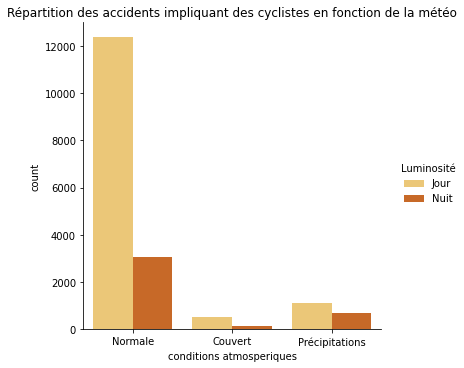

In [20]:
#On affiche à l'utilisateur la météo qu'il fait, tout en faisant un peu de prévention, car il faut toujours être vigolant

if meteo_idf_temps_reel['precipitations mm/h'].item()> 2.000 and (meteo_idf_temps_reel['2_metre_temperature'].item() > -1 or meteo_idf_temps_reel['2_metre_temperature'].item()) < 1:
    print("Attention il pleut et il y a peut-être du verglas sur la chaussée car la température est de", round(meteo_idf_temps_reel['2_metre_temperature'].item(),1),"degrès." )

elif meteo_idf_temps_reel['precipitations mm/h'].item() > 2.000 and (meteo_idf_temps_reel['2_metre_temperature'].item() < -1 or meteo_idf_temps_reel['2_metre_temperature'].item()) > 1:
    print("Attention il pleut, mais normalement, il n'y a pas de verglas sur la chaussée. La témpérature est de ", round(meteo_idf_temps_reel['2_metre_temperature'].item(),1),"degrès." )

elif meteo_idf_temps_reel['precipitations mm/h'].item() < 2.00 and (meteo_idf_temps_reel['2_metre_temperature'].item() > -1 or meteo_idf_temps_reel['2_metre_temperature'].item()) < 1:
    print("Il ne pleut pas, mais attention, il peut y avoir du verglas sur votre trajet.")

else:
    print("Quel chanceux, il n'y a ni pluie ni verglas pour votre trajet à vélo et la température est de",round(meteo_idf_temps_reel['2_metre_temperature'].item(),1),"degrès.")
    print("Pourtant, il faut quand même faire attention, car de nombreux accidents ont lieu dans des conditions atmosphériques normales.\nPour vous en convaincre, regardez ce graphique présentant le nombre d'accidents impliquant des cyclistes ayant eu lieu entre 2005 et 2018 en Ile-de-France.")
    category_order = ['Normale', 'Couvert', 'Précipitations']

    #On fait un graphique représentant le nombre d'accident en fonction des conditions atmosphériques
    g = sns.catplot(x='conditions atmosperiques',
            hue = 'luminosite', palette="YlOrBr", 
            data=accident_velo_idf_meteo, kind='count', order=category_order);

    plt.title('Répartition des accidents impliquant des cyclistes en fonction de la météo')
    g._legend.set_title('Luminosité')

    plt.show()